In [1]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

In [2]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:10]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551']
15.515060297068947
15.802872967471835
11.08458774068679
8.97542529762611
15.460752938661816
8.097196263848735
3.5471797714338695
4.73231500896138
3.547176454921115
4.544545768066009


In [3]:
noise_params

{'B1855+09_430_ASP_efac': 1.115935306813982,
 'B1855+09_430_ASP_log10_t2equad': -7.564164330699591,
 'B1855+09_430_PUPPI_efac': 1.000049037085653,
 'B1855+09_430_PUPPI_log10_t2equad': -6.572540211467256,
 'B1855+09_L-wide_ASP_efac': 1.043114017270374,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.517929916655293,
 'B1855+09_L-wide_PUPPI_efac': 1.1118432332882,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -7.755603780476984,
 'B1855+09_430_ASP_log10_ecorr': -6.798122106550257,
 'B1855+09_430_PUPPI_log10_ecorr': -5.6989064141929715,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.120457109433745,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641667916624413,
 'B1855+09_red_noise_log10_A': -13.940953818371378,
 'B1855+09_red_noise_gamma': -3.68432133461766,
 'B1937+21_L-wide_ASP_efac': 2.584236583895852,
 'B1937+21_L-wide_ASP_log10_t2equad': -7.240258825889674,
 'B1937+21_L-wide_PUPPI_efac': 1.588553615548855,
 'B1937+21_L-wide_PUPPI_log10_t2equad': -7.316718019537581,
 'B1937+21_Rcvr1_2_GASP_efac': 1.1159623803

In [4]:
parDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/pars/'
timDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/tims/'
psrlist = sorted(glob.glob(parDir+'*.par'))
for _ in range(len(psrlist)):
    psrlist[_] = re.sub(parDir, '', psrlist[_])
    psrlist[_] = re.sub('_NANOGrav_12yv2.gls.par', '', psrlist[_])
parfiles = sorted(glob.glob(parDir+'*.par'))
timfiles = sorted(glob.glob(timDir+'*.tim'))
psrs_sim = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs_sim.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [5]:
#Loading in pickle and noise files
noise_file_sim = "/home/reyna/BayesHopperBurst/BenceData/with_burst/params_simulated.json"
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file_sim, 'r') as h:
    noise_params_sim = json.load(h)
#Temporary to get code to not crash
psrs_sim = psrs_sim[0:]
psrlist = [psr.name for psr in psrs_sim]
print(psrlist)
for i in range(len(psrs_sim)):
    print((max(psrs_sim[i].toas) - min(psrs_sim[i].toas))/(3.17*10**(7)))

['JPSR00', 'JPSR01', 'JPSR02', 'JPSR03', 'JPSR04', 'JPSR05', 'JPSR06', 'JPSR07', 'JPSR08', 'JPSR09', 'JPSR10', 'JPSR11', 'JPSR12', 'JPSR13', 'JPSR14', 'JPSR15', 'JPSR16', 'JPSR17', 'JPSR18', 'JPSR19']
9.893753204746307
9.893759921988087
9.893754816178342
9.893759889756392
9.893756654153247
9.89375896654812
9.89374832210285
9.893748096020424
9.893750286241795
9.893749272324294
9.893753811469935
9.893755879824756
9.893755364731359
9.893753943159542
9.893749736614438
9.893753781387016
9.89374939925585
9.893756353323933
9.893749681974015
9.893756930578485


In [6]:
noise_dict_sim = {} #new noise dict to conver the simulated noise file into a readable formate
for k,v in noise_params_sim.items():
    if '_equad' in k:
        noise_dict_sim.update({k.split('_equad')[0] + '_t2equad': v})
    else:
        noise_dict_sim.update({k : v})

In [7]:
noise_dict_sim

{'JPSR00_efac': 1.0,
 'JPSR01_efac': 1.0,
 'JPSR02_efac': 1.0,
 'JPSR03_efac': 1.0,
 'JPSR04_efac': 1.0,
 'JPSR05_efac': 1.0,
 'JPSR06_efac': 1.0,
 'JPSR07_efac': 1.0,
 'JPSR08_efac': 1.0,
 'JPSR09_efac': 1.0,
 'JPSR10_efac': 1.0,
 'JPSR11_efac': 1.0,
 'JPSR12_efac': 1.0,
 'JPSR13_efac': 1.0,
 'JPSR14_efac': 1.0,
 'JPSR15_efac': 1.0,
 'JPSR16_efac': 1.0,
 'JPSR17_efac': 1.0,
 'JPSR18_efac': 1.0,
 'JPSR19_efac': 1.0,
 'JPSR00_log10_t2equad': -17,
 'JPSR01_log10_t2equad': -17,
 'JPSR02_log10_t2equad': -17,
 'JPSR03_log10_t2equad': -17,
 'JPSR04_log10_t2equad': -17,
 'JPSR05_log10_t2equad': -17,
 'JPSR06_log10_t2equad': -17,
 'JPSR07_log10_t2equad': -17,
 'JPSR08_log10_t2equad': -17,
 'JPSR09_log10_t2equad': -17,
 'JPSR10_log10_t2equad': -17,
 'JPSR11_log10_t2equad': -17,
 'JPSR12_log10_t2equad': -17,
 'JPSR13_log10_t2equad': -17,
 'JPSR14_log10_t2equad': -17,
 'JPSR15_log10_t2equad': -17,
 'JPSR16_log10_t2equad': -17,
 'JPSR17_log10_t2equad': -17,
 'JPSR18_log10_t2equad': -17,
 'JPSR19_l

In [8]:
glitches = []
log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(1)+'_'+'log10_f0')
phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(1)+'_'+'phase0')
tau = parameter.Uniform(0.2, 5)("Glitch_"+str(1)+'_'+'tau')
t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(1)+'_'+'t0')
psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(1)+'_'+'psr_idx')
log10_h = parameter.LinearExp(-6.5, -5)("Glitch_"+str(1)+'_'+'log10_h')
glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                        psr_float_idx = psr_idx, pulsars=psrs)
glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(1) ))

In [9]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [10]:
glitches_sim = []
log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(1)+'_'+'log10_f0')
phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(1)+'_'+'phase0')
tau = parameter.Uniform(0.2, 5)("Glitch_"+str(1)+'_'+'tau')
t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(1)+'_'+'t0')
psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(1)+'_'+'psr_idx')
log10_h = parameter.LinearExp(-10.5, -9)("Glitch_"+str(1)+'_'+'log10_h')
glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                        psr_float_idx = psr_idx, pulsars=psrs_sim)
glitches_sim.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(1) ))

In [11]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches_sim[0]
model_sim = []
for p in psrs_sim:
    model_sim.append(s(p))
# with open(noise_file_sim, 'r') as fp:
#     noisedict = json.load(fp)
pta_sim = signal_base.PTA(model_sim)
pta_sim.set_default_params(noise_dict_sim)

In [14]:
d0_15y = parameter.sample(pta.params)
x0_15y = np.array([d0_15y[par.name] for par in pta.params])

In [15]:
d0_15y = {
    'Glitch_1_log10_f0':np.log10(6e-8),
#    'Glitch_1_log10_h':np.log10(1e-5), #medium amp
    'Glitch_1_log10_h':np.log10(2e-10), #low amp
#    'Glitch_1_log10_h':np.log10(1e-6), #very low amp
    'Glitch_1_phase0':1.0,
    'Glitch_1_psr_idx':0.2,#0.0 should be what is in file
    'Glitch_1_t0':2500.0/365.25, #year
    'Glitch_1_tau':300.0/365.25, #year
}
x0_15y = np.array([d0_15y[par.name] for par in pta_sim.params])

In [73]:
d0 = {
    'Glitch_1_log10_f0':np.log10(6e-8),
#    'Glitch_1_log10_h':np.log10(1e-5), #medium amp
    'Glitch_1_log10_h':np.log10(8e-6), #low amp
#    'Glitch_1_log10_h':np.log10(1e-6), #very low amp
    'Glitch_1_phase0':1.0,
    'Glitch_1_psr_idx':0.2,#0.0 should be what is in file
    'Glitch_1_t0':2500.0/365.25, #year
    'Glitch_1_tau':300.0/365.25, #year
}
x0 = np.array([d0[par.name] for par in pta_sim.params])

In [74]:
pta_sim.get_lnlikelihood(x0)

24070.645014873262

In [18]:
pta.get_lnlikelihood(x0_15y)

756174.2945150377

In [19]:
#low amp
9851.87556366824
9851.206424317403
9899.326326767134

9899.326326767134

In [20]:
24066.135120429506
24522.95538027728
24523.62451962812
24070.645014873262

23148.380091697676

In [21]:
len(psrs_sim)

20

In [22]:
d0

{'Glitch_1_log10_f0': -7.221848749616356,
 'Glitch_1_log10_h': -5.698970004336019,
 'Glitch_1_phase0': 1.0,
 'Glitch_1_psr_idx': 0.2,
 'Glitch_1_t0': 6.844626967830253,
 'Glitch_1_tau': 0.8213552361396304}

In [80]:
import Fast_Burst_likelihood as FB

In [76]:
FB1 = FB.FastBurst(pta = pta_sim, psrs = psrs_sim, params = d0, Npsr = len(psrs_sim), tref=53000*86400)

Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5

In [72]:
FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]), (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3])

Input time:  2495.4369153547796
adding in resres_logdet 24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728
LogL:  24522.95538027728


24522.95538027728

In [ ]:
24523.62451962812

In [81]:
NN = 20

log_L_Ent = []
log_L_Fast = []
amplitudes = []

for i in range(NN):
    amplitudes.append(i*0.5e-6)
    d0 = {
        'Glitch_1_log10_f0':np.log10(6e-8),
        'Glitch_1_log10_h':np.log10(amplitudes[i]), #low amp
        'Glitch_1_phase0':1.0,
        'Glitch_1_psr_idx':0.2,#0.0 should be what is in file
        'Glitch_1_t0':2500.0/365.25, #year
        'Glitch_1_tau':300.0/365.25, #year
    }
    x0 = np.array([d0[par.name] for par in pta_sim.params])
    
    FB1 = FB.FastBurst(pta = pta_sim, psrs = psrs_sim, params = d0, Npsr = len(psrs_sim), tref=53000*86400)
    
    log_L_Ent.append(pta_sim.get_lnlikelihood(x0))
    log_L_Fast.append(FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]),
                                           (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3]))

log_L_Ent = np.array(log_L_Ent)
log_L_Fast = np.array(log_L_Fast)

/tmp/ipykernel_9498/1380436549.py:11: RuntimeWarning: divide by zero encountered in log10


Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5

[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40

[(KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (Kernel

[(KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (KernelMatrix([1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40, 1.e-40,
              1.e-40]), KernelMatrix(736.82722976)), (Kernel

[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40

[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40

[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40 1.e-40]
[1.e-40 1.e-40

Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5

adding in resres_logdet 24474.69849525429
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
LogL:  24265.323628744492
Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2

adding in resres_logdet 24474.69849525429
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
LogL:  24139.285091661295
Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2

Nvecs arary:  [[2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5e-13
 2.5e-13 2.5e-13 2.5e-13 2.5e-13 2.5

adding in resres_logdet 24474.69849525429
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008
LogL:  23812.146402168008


Text(0, 0.5, 'log(likelihood)')

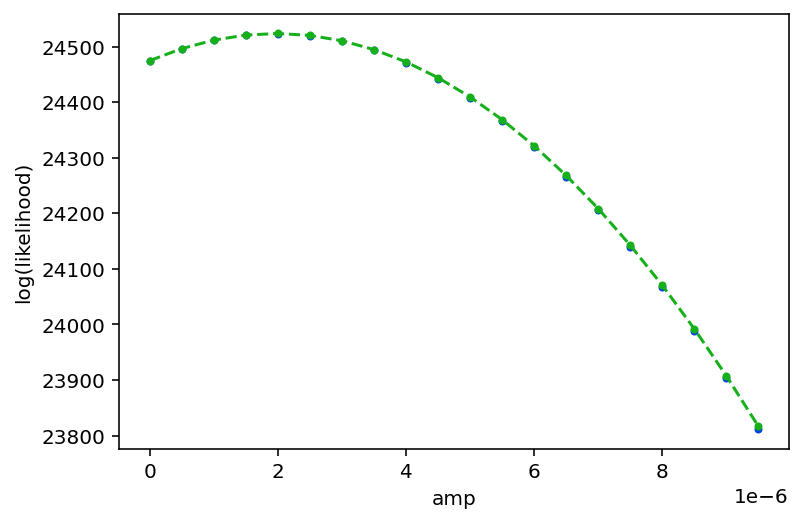

In [82]:
plt.plot(amplitudes, log_L_Fast, ls='', marker='.', color='xkcd:blue')
plt.plot(amplitudes, log_L_Ent, ls='--', marker='.', color='xkcd:green')
plt.xlabel("amp")
plt.ylabel("log(likelihood)")

Text(0, 0.5, 'delta log(likelihood)')

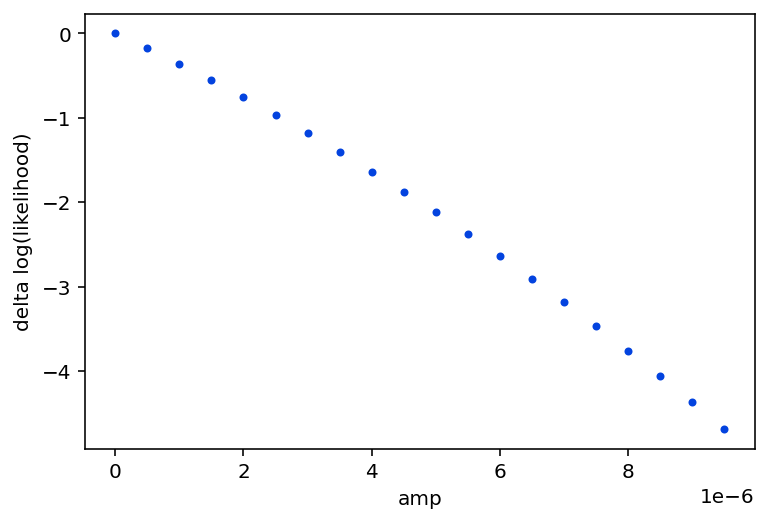

In [84]:
plt.plot(amplitudes, log_L_Fast-log_L_Ent, ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("amp")
plt.ylabel("delta log(likelihood)")
#plt.yscale('log')

Text(0, 0.5, 'precent diff log(likelihood)')

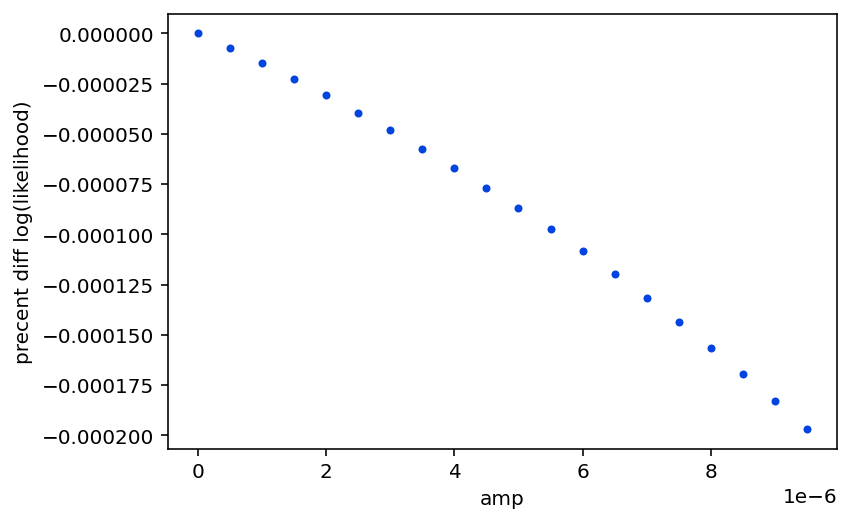

In [85]:
plt.plot(amplitudes, log_L_Fast/log_L_Ent - 1., ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("amp")
plt.ylabel("precent diff log(likelihood)")
#plt.yscale('log')

[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]
[ 5.13287191e-06 -7.99397436e-06]


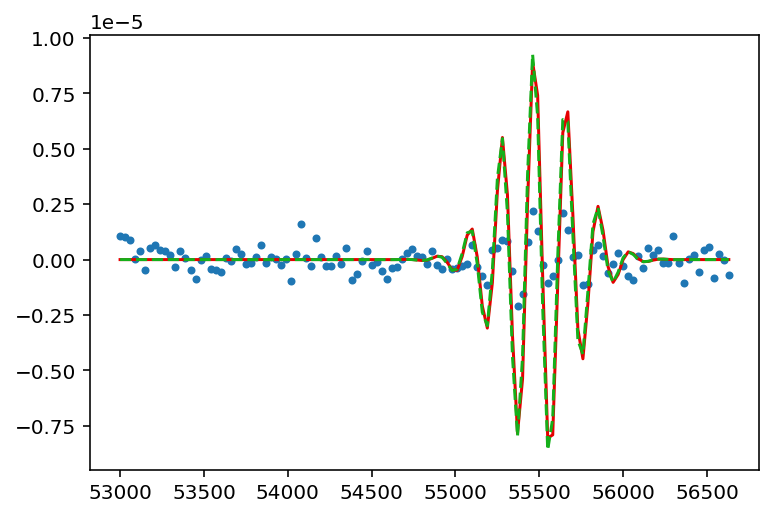

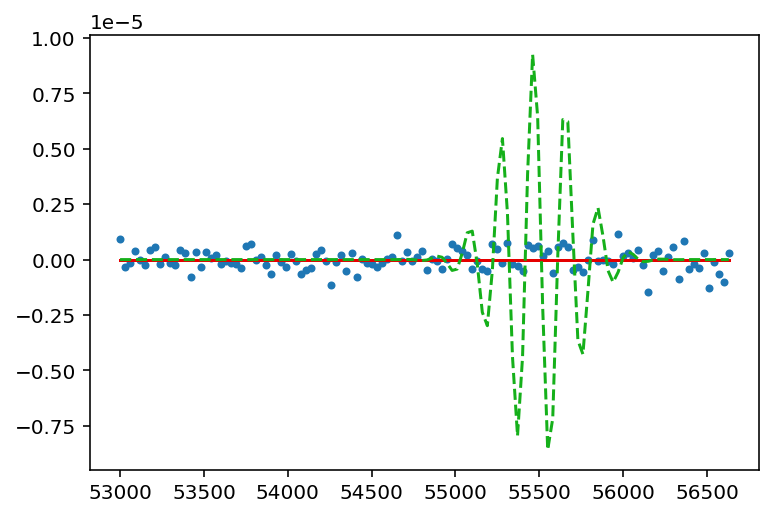

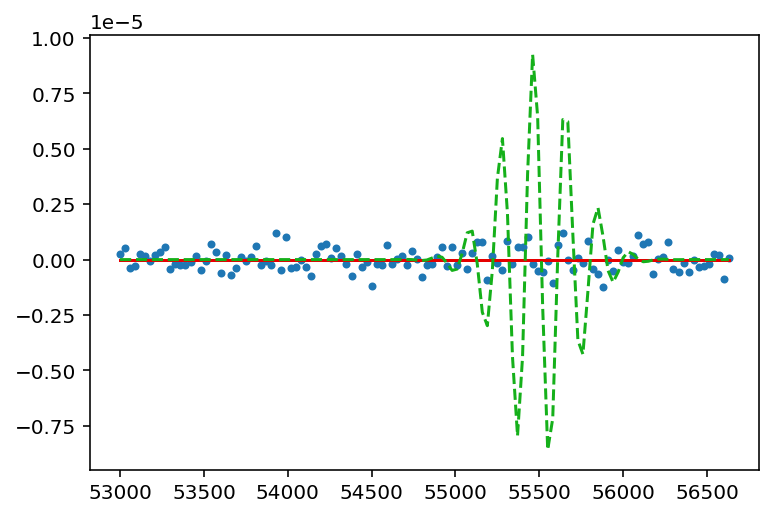

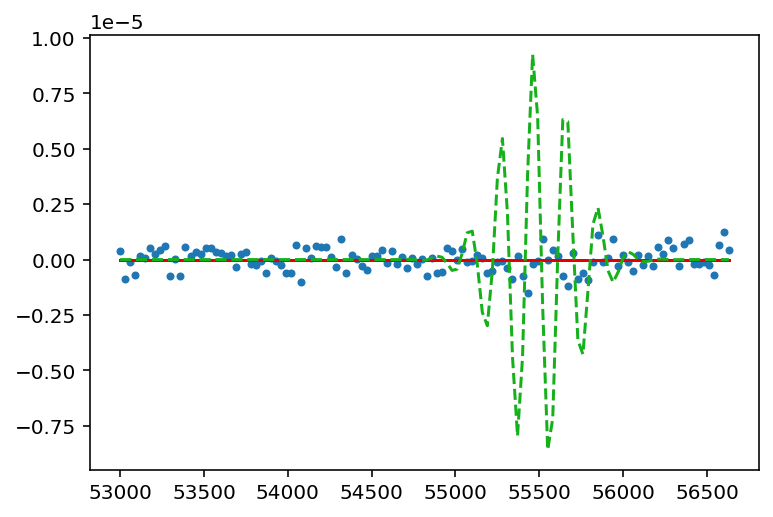

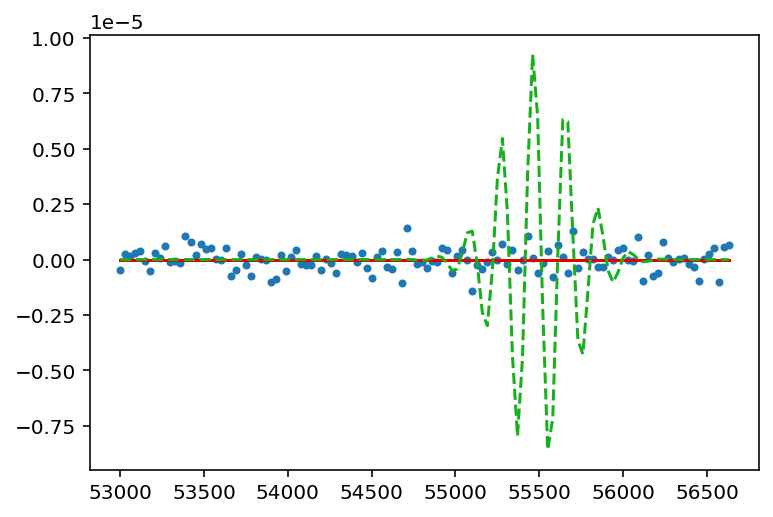

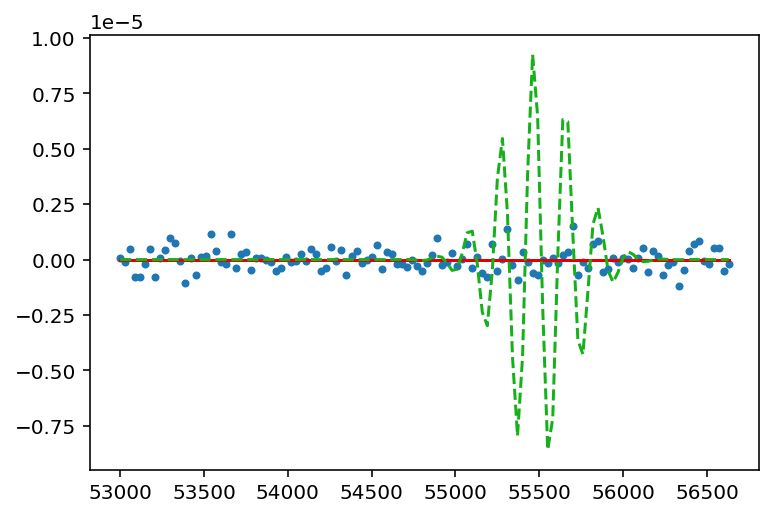

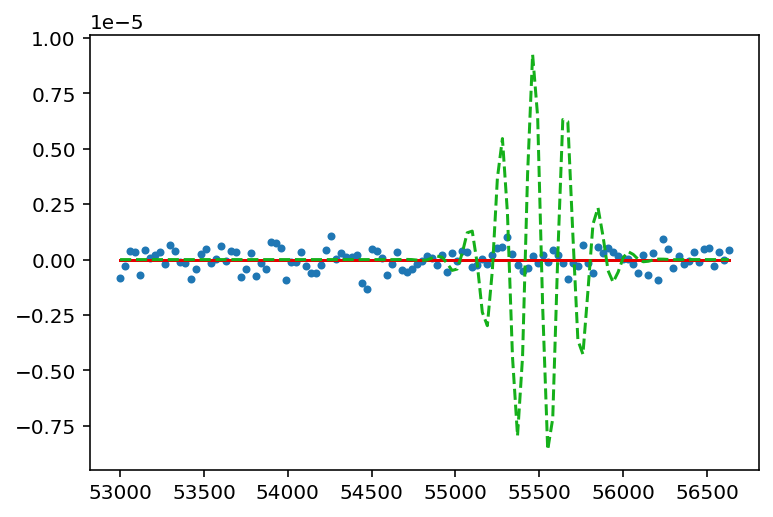

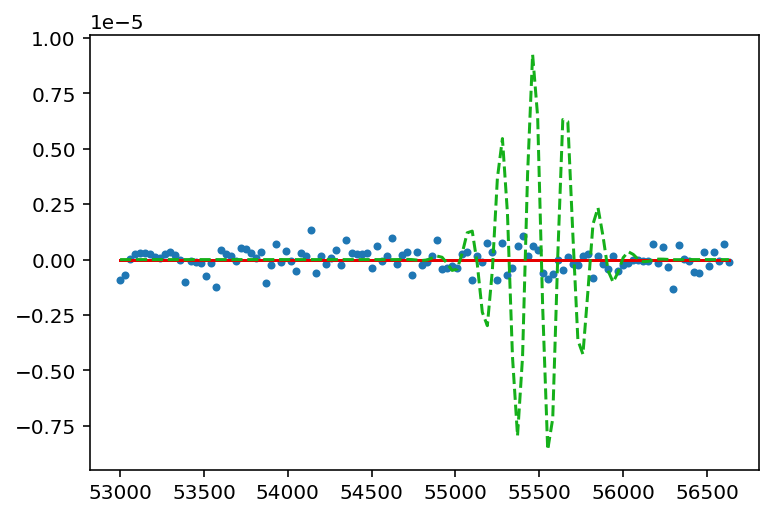

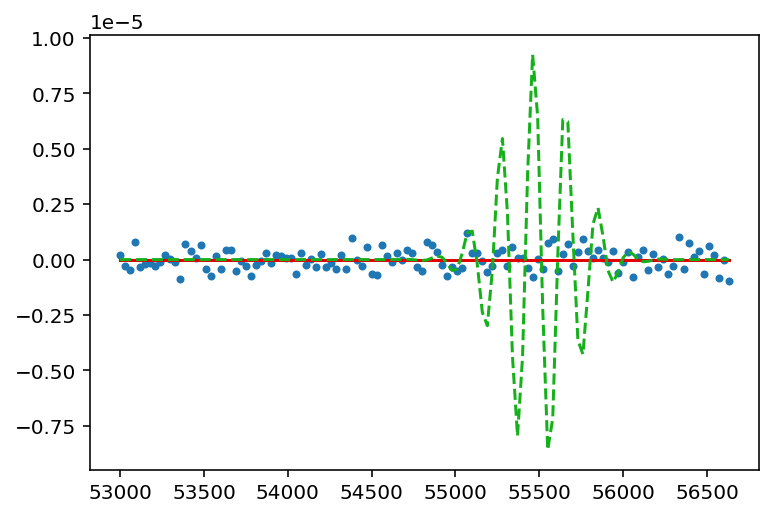

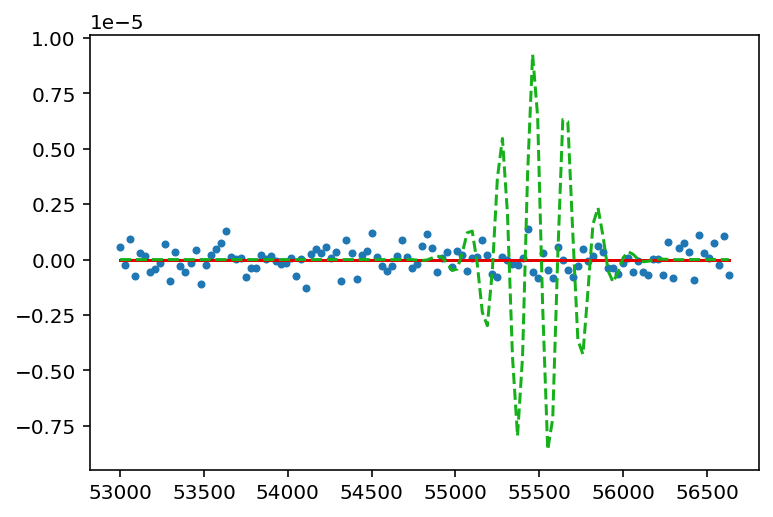

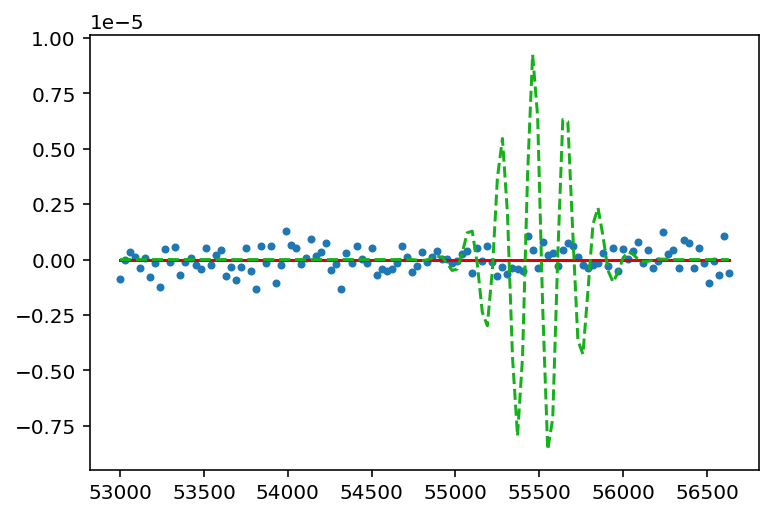

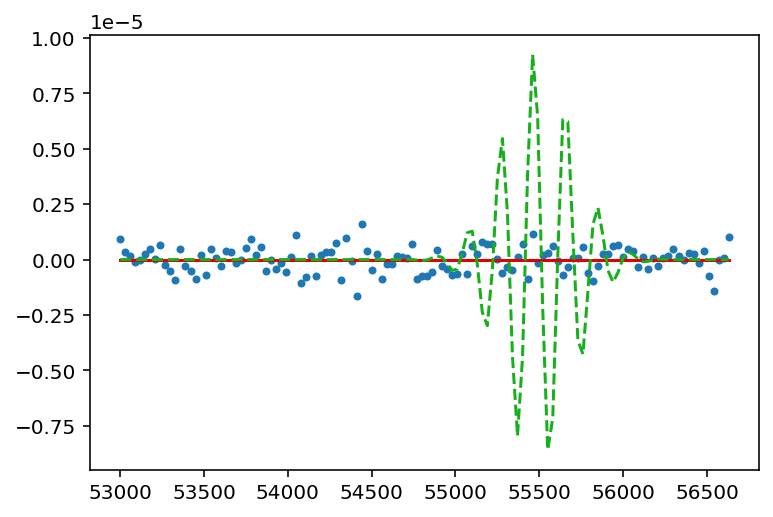

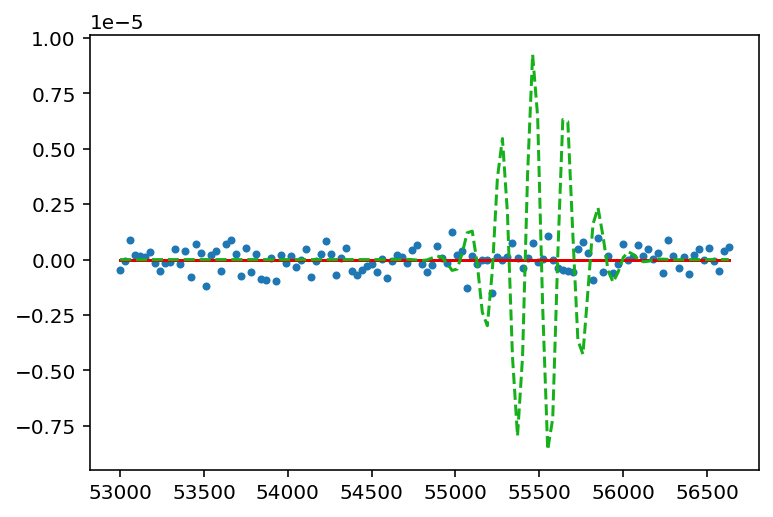

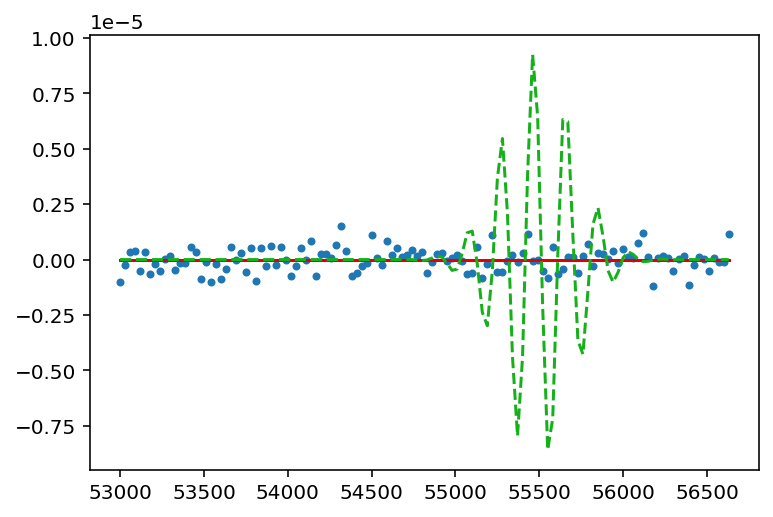

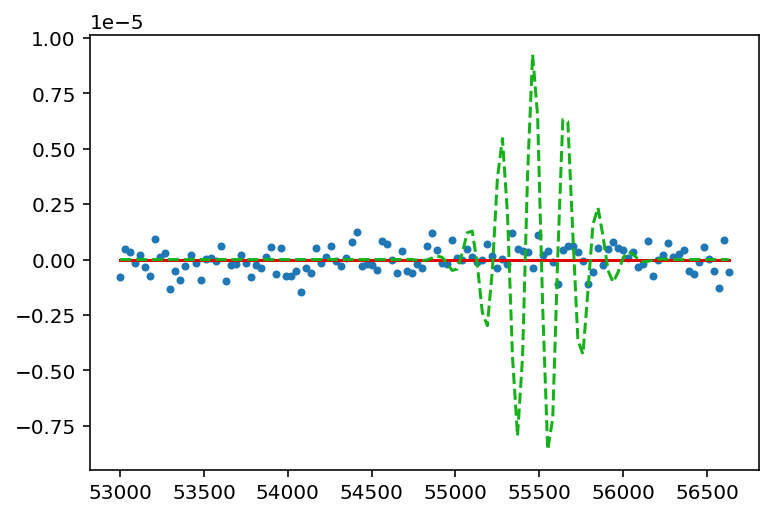

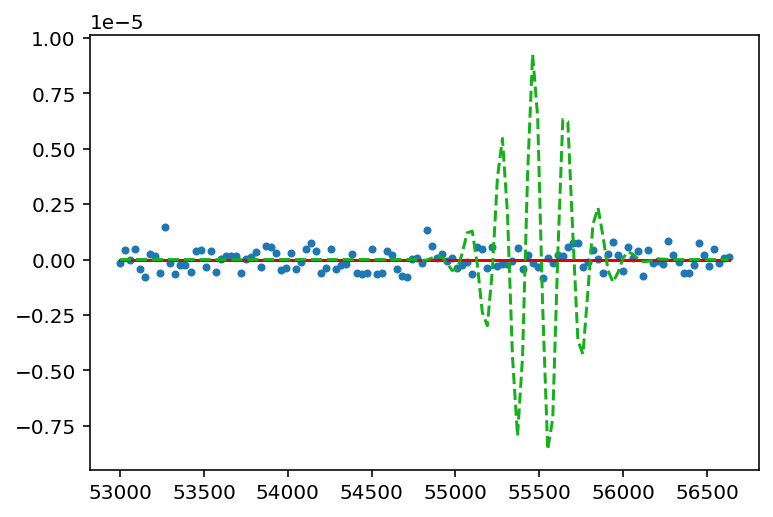

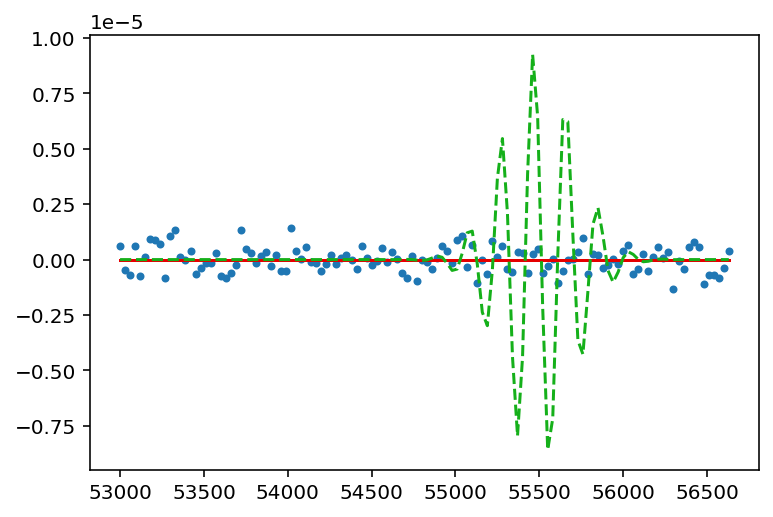

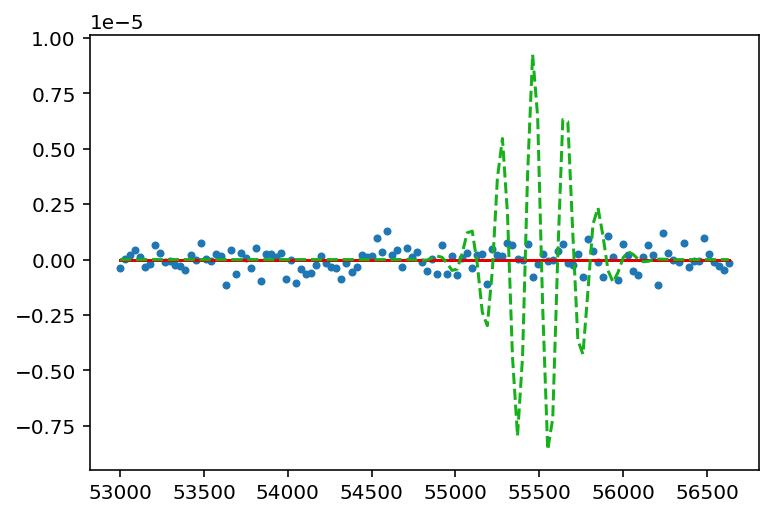

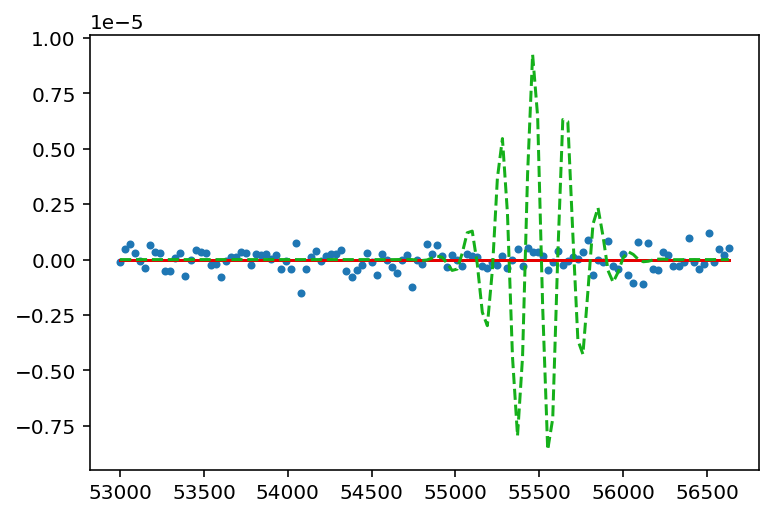

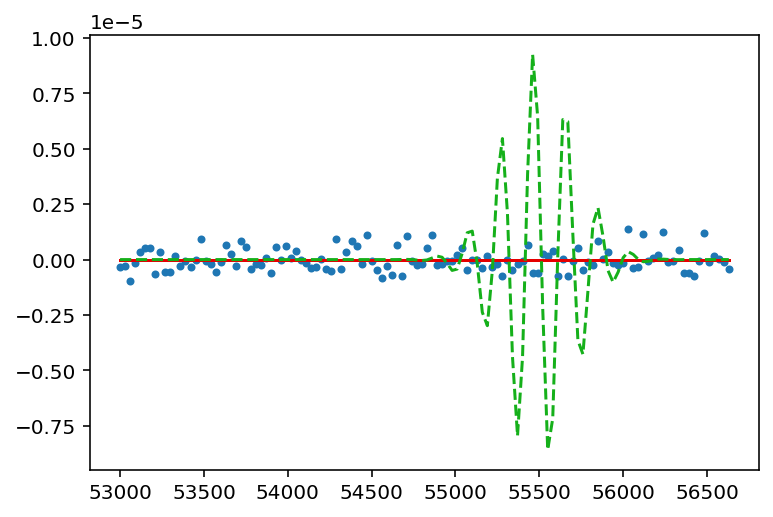

In [30]:
for i, psr in enumerate(psrs_sim):
    plt.figure(i)
    plt.plot(psr.toas/86400, psr.residuals, ls='', marker='.')
    plt.plot(psr.toas/86400, pta_sim.get_delay(d0)[i],color='xkcd:red')
    
    f0 = 10**(x0[0])
    tau = (3.15*10**7)*x0[5]
    t0 = (3.15*10**7)*x0[4]
    
    Cosine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.cos(2*np.pi*f0*(FB1.toas[i] - t0))
    Sine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.sin(2*np.pi*f0*(FB1.toas[i] - t0))
    print(FB1.sigma)
    fast_delay = FB1.sigma[0]*Cosine + FB1.sigma[1]*Sine
    plt.plot(psr.toas/86400, fast_delay, ls='--',color='xkcd:green')